In [ ]:
#@title 🧱 1) Instalar dependencias + Ollama + DeepSeek-R1 8B (persistente en Drive)
DRIVE_PROJECT_FOLDER = "Hackathon Bria Fibo" #@param {type:"string"}
OLLAMA_MODEL = "deepseek-r1:8b" #@param {type:"string"}
FORCE_REMOUNT_DRIVE = True #@param {type:"boolean"}
PULL_MODEL_IF_MISSING = True #@param {type:"boolean"}

import os, time, subprocess
from pathlib import Path
from google.colab import drive

# 1) Montar Drive
drive.mount("/content/drive", force_remount=FORCE_REMOUNT_DRIVE)
DRIVE_ROOT = Path("/content/drive/MyDrive") / DRIVE_PROJECT_FOLDER
DRIVE_ROOT.mkdir(parents=True, exist_ok=True)
print("✅ Drive listo en:", DRIVE_ROOT)

# 2) Dependencias Python (Bria FIBO se consume vía API v2; no se instala el modelo)
!pip -q install fastapi "uvicorn[standard]" python-multipart pydantic requests pillow tqdm \
                 faiss-cpu sentence-transformers ollama

# 3) Instalar Ollama
!curl -fsSL https://ollama.com/install.sh | sh

# Cache persistente de modelos en Drive (OLLAMA_MODELS)
OLLAMA_MODELS_DIR = DRIVE_ROOT / "ollama_models"
OLLAMA_MODELS_DIR.mkdir(parents=True, exist_ok=True)
os.environ["OLLAMA_MODELS"] = str(OLLAMA_MODELS_DIR)
print("📦 OLLAMA_MODELS =", os.environ["OLLAMA_MODELS"])

# Levantar daemon
!nohup ollama serve > /tmp/ollama.log 2>&1 &
time.sleep(2)

# Descargar modelo (si falta)
if PULL_MODEL_IF_MISSING:
    existing = subprocess.getoutput("ollama list")
    if OLLAMA_MODEL in existing:
        print(f"✅ Modelo ya presente: {OLLAMA_MODEL}")
    else:
        print(f"⬇️ Descargando modelo: {OLLAMA_MODEL} (queda cacheado en Drive)")
        !ollama pull {OLLAMA_MODEL}

print("✅ Modelos disponibles:")
!ollama list


Mounted at /content/drive
✅ Drive listo en: /content/drive/MyDrive/Hackathon Bria Fibo
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.7/517.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.8/456.8 kB 30.3 MB/s eta 0:00:00
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
📦 OLLAMA_MODELS = /content/drive/MyDrive/Hackathon Bria Fibo/ollama_models
⬇️ Descargando modelo: deepseek-r1:8b (queda cacheado en Drive)

✅ Modelos disponibles:
NAME            

In [ ]:
#@title 📚 RAG (Knowledge Base) — Guidelines pro para JSON patches (cámara/temperatura/filtros) ✅
DRIVE_PROJECT_FOLDER = "Hackathon Bria Fibo" #@param {type:"string"}
SERVICE_FOLDER_NAME = "llm_rag_service" #@param {type:"string"}

OVERWRITE_KB = True #@param {type:"boolean"}

# --- Brand defaults (puedes cambiarlos sin tocar código)
BRAND_NAME = "Generic Brand" #@param {type:"string"}
PRIMARY_COLOR_HEX = "#FF5733" #@param {type:"string"}
SECONDARY_COLOR_HEX = "#FFFFFF" #@param {type:"string"}
BRAND_VIBE = "Premium minimal, clean, modern" #@param {type:"string"}

# --- Visual defaults
DEFAULT_COLOR_TEMPERATURE_K = 5600 #@param {type:"integer"}  # 3200 warm / 5600 neutral / 6500 cool
DEFAULT_CONTRAST = "medium" #@param {type:"string"}          # low / medium / high
DEFAULT_SATURATION = "medium" #@param {type:"string"}        # low / medium / high
DEFAULT_SHARPNESS = "medium" #@param {type:"string"}         # low / medium / high

# --- Camera & lighting presets
ALLOW_CAMERA_ANGLES = "eye-level, three-quarter, low-angle, top-down flat lay, macro close-up" #@param {type:"string"}
ALLOW_LIGHTING = "studio softbox, golden hour, rim light, diffused top light, overcast daylight" #@param {type:"string"}

# --- Post-processing “filters”
ALLOW_FILTERS = "subtle film grain, gentle vignette, soft bloom (very light), clarity boost (moderate), background bokeh" #@param {type:"string"}

from pathlib import Path
from google.colab import drive
import textwrap, datetime

drive.mount("/content/drive", force_remount=False)

SERVICE_DIR = Path("/content/drive/MyDrive") / DRIVE_PROJECT_FOLDER / SERVICE_FOLDER_NAME
RAG_DIR = SERVICE_DIR / "rag"
RAG_DIR.mkdir(parents=True, exist_ok=True)

kb_path = RAG_DIR / "kb.txt"
brand_tpl_path = RAG_DIR / "brand_guidelines_template.txt"

timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

kb_text = f"""
# ============================
# Bria FIBO — RAG Knowledge Base
# Generated: {timestamp}
# Location: {kb_path}
# ============================

[ES] Objetivo:
- Ayudar al LLM (planner) a generar *JSON patches* que se mezclan (deep-merge) con el structured_prompt base.
- Los patches deben mejorar composición, cámara, iluminación, “temperatura” (color temperature) y post-proceso sin romper identidad del producto.

[EN] Goal:
- Help the LLM produce *JSON patch objects* to deep-merge into the base structured_prompt.
- Improve camera, lighting, color temperature and post-processing while keeping product identity stable.

------------------------------------------------------------
A) REGLAS DE ORO (NO ROMPER)
------------------------------------------------------------
1) Preserve product identity:
   - Do NOT change brand name or invent logos.
   - Keep label readable.
   - Keep product centered and not deformed.

2) Patch = partial JSON only:
   - Output ONLY an array of N patch objects (each is a dict).
   - Minimal edits: touch only relevant keys.

3) Safety for schema:
   - Prefer keys that already exist in base structured_prompt.
   - If you must add new detail: embed it as descriptive text inside existing fields (e.g., lighting.conditions).

------------------------------------------------------------
B) KEYS RECOMENDADAS (patch-friendly)
------------------------------------------------------------
Use / modify (if present in base):
- lighting: {{
    conditions: "studio softbox, neutral 5600K",
    notes: "soft shadows"
  }}

- photographic_characteristics: {{
    camera_angle: "eye-level | three-quarter | low-angle | top-down flat lay | macro close-up",
    depth_of_field: "shallow | medium | deep",
    lens_style: "85mm portrait | 35mm product | macro"
  }}

- background_setting: "clean studio gradient | subtle lifestyle bokeh | dark premium backdrop | flat lay surface"

- aesthetics: {{
    mood_atmosphere: "premium minimal | warm aspirational | bold luxury | editorial clean",
    color_scheme: "brand-aligned (primary accent {PRIMARY_COLOR_HEX})",
    style_notes: "high-end product photography"
  }}

Optional if base supports it (or add as text inside existing fields):
- post_processing / color_grading:
  - contrast: "{DEFAULT_CONTRAST}"
  - saturation: "{DEFAULT_SATURATION}"
  - sharpness: "{DEFAULT_SHARPNESS}"
  - filters: "{ALLOW_FILTERS}"

------------------------------------------------------------
C) “TEMPERATURA” DE LA IMAGEN (Color Temperature)
------------------------------------------------------------
Preferred approach (safe):
- Put the temperature inside lighting.conditions string:
  - "studio softbox, {DEFAULT_COLOR_TEMPERATURE_K}K neutral daylight"

If base has a numeric field, you MAY set:
- lighting.color_temperature_k: 3200..7000

Typical values:
- 3200K: warm tungsten (cozy)
- 4500K: warm-neutral (late afternoon)
- 5600K: neutral daylight (clean ecommerce)
- 6500K: cool daylight (tech/clinical)

------------------------------------------------------------
D) CÁMARA (ángulo + intención)
------------------------------------------------------------
Allowed angles: {ALLOW_CAMERA_ANGLES}

Guidance:
- eye-level: standard ecommerce hero shot
- three-quarter: dynamic + depth
- low-angle: “hero” / powerful
- top-down flat lay: layout/props, editorial
- macro close-up: texture/material detail

------------------------------------------------------------
E) FILTROS / POST-PROCESS (sin pasarse)
------------------------------------------------------------
Allowed filters: {ALLOW_FILTERS}

Rules:
- Prefer subtle: “subtle film grain” not heavy noise.
- Vignette: gentle only.
- Bloom: very light (or none) unless explicitly requested.
- Keep label readable: avoid heavy blur over the product.

------------------------------------------------------------
F) DO / DON'T (muy importante)
------------------------------------------------------------
DO:
- Keep product in focus.
- Use consistent brand accent color ({PRIMARY_COLOR_HEX}).
- Keep backgrounds clean and non-distracting.
- Ensure professional lighting and coherent shadows.

DON'T:
- Don't create text on label that wasn't there.
- Don't change product shape or proportions.
- Don't place heavy props that hide the product.
- Don't apply extreme color filters that distort brand colors.

------------------------------------------------------------
G) CÓMO ESCRIBIR GUIDELINES (para tu campo brand_guidelines)
------------------------------------------------------------
[EN Template style]
- Brand name:
- Primary color:
- Secondary color:
- Mood:
- Camera preferences:
- Lighting preferences:
- Color temperature:
- Post-processing:
- Forbidden:
- Must-have:

[ES Consejo]
- Mantén tus reglas como bullets cortos.
- Si quieres control fuerte: usa "MUST:" y "FORBIDDEN:".

------------------------------------------------------------
H) EJEMPLOS DE PATCHES JSON (copy/paste)
------------------------------------------------------------
Example 1 (Neutral studio ecommerce):
{{
  "lighting": {{"conditions": "studio softbox, 5600K neutral daylight, soft shadows"}},
  "photographic_characteristics": {{"camera_angle": "eye-level", "depth_of_field": "shallow", "lens_style": "85mm portrait"}},
  "background_setting": "clean premium studio background",
  "aesthetics": {{"mood_atmosphere": "premium minimal", "color_scheme": "brand-aligned (accent {PRIMARY_COLOR_HEX})"}}
}}

Example 2 (Golden hour lifestyle bokeh):
{{
  "lighting": {{"conditions": "golden hour, warm highlights, gentle shadows (≈4500K)"}},
  "photographic_characteristics": {{"camera_angle": "three-quarter", "depth_of_field": "medium", "lens_style": "35mm product"}},
  "background_setting": "subtle lifestyle scene with bokeh (out-of-focus)",
  "aesthetics": {{"mood_atmosphere": "warm aspirational", "color_scheme": "warm neutrals + accent {PRIMARY_COLOR_HEX}"}}
}}

Example 3 (Dark premium hero):
{{
  "lighting": {{"conditions": "dramatic rim light, controlled reflections, high-end studio"}},
  "photographic_characteristics": {{"camera_angle": "low-angle", "depth_of_field": "shallow"}},
  "background_setting": "dark premium backdrop with subtle gradient",
  "aesthetics": {{"mood_atmosphere": "bold luxury", "color_scheme": "dark + accent {PRIMARY_COLOR_HEX}"}}
}}

Example 4 (Flat lay editorial + subtle filters):
{{
  "lighting": {{"conditions": "diffused top light, soft even illumination (≈5600K)"}},
  "photographic_characteristics": {{"camera_angle": "top-down flat lay", "depth_of_field": "deep"}},
  "background_setting": "flat lay surface (stone/wood), minimal props",
  "aesthetics": {{"mood_atmosphere": "editorial clean", "color_scheme": "neutral + accent {PRIMARY_COLOR_HEX}", "style_notes": "subtle film grain, gentle vignette, moderate clarity"}}
}}

"""

brand_template = f"""
# Brand Guidelines Template (paste into request field: brand_guidelines)

Brand name: {BRAND_NAME}
Primary color: {PRIMARY_COLOR_HEX}
Secondary color: {SECONDARY_COLOR_HEX}
Brand vibe: {BRAND_VIBE}

MUST:
- Keep product identity intact and label readable
- Keep product centered and in focus
- Use accent color {PRIMARY_COLOR_HEX} subtly in background/tones
- Professional product photography look

Camera preferences:
- Allowed angles: {ALLOW_CAMERA_ANGLES}
- Prefer: eye-level or three-quarter for hero images
- Avoid: extreme fisheye / warped perspective

Lighting preferences:
- Allowed: {ALLOW_LIGHTING}
- Prefer: studio softbox for clean ecommerce
- Optional: golden hour for lifestyle variant

Color temperature:
- Default: {DEFAULT_COLOR_TEMPERATURE_K}K
- Warm variant: 4500K (golden hour feel)
- Cool variant: 6500K (tech/clinical feel)

Post-processing:
- Contrast: {DEFAULT_CONTRAST}
- Saturation: {DEFAULT_SATURATION}
- Sharpness: {DEFAULT_SHARPNESS}
- Allowed filters: {ALLOW_FILTERS}
- Keep it subtle: no heavy stylization

FORBIDDEN:
- Inventing logos or changing text on the product label
- Heavy blur that reduces label readability
- Extreme color filters that distort brand colors
"""

if OVERWRITE_KB or (not kb_path.exists()):
    kb_path.write_text(kb_text.strip() + "\n", encoding="utf-8")
else:
    kb_path.write_text((kb_path.read_text(encoding="utf-8") + "\n\n" + kb_text.strip() + "\n"), encoding="utf-8")

brand_tpl_path.write_text(brand_template.strip() + "\n", encoding="utf-8")

print("✅ RAG KB listo:")
print(" -", kb_path)
print("✅ Template para brand_guidelines listo:")
print(" -", brand_tpl_path)

print("\n📌 Preview (primeras 60 líneas de kb.txt):\n")
lines = kb_path.read_text(encoding="utf-8").splitlines()
print("\n".join(lines[:60]))

print("\n📌 Tip de uso:")
print("1) Deja kb.txt como base global (RAG).")
print("2) En cada request, pega brand_guidelines_template.txt (o un derivado) en el campo brand_guidelines.")
print("3) El LLM usará esto para producir patches JSON más ricos (cámara/temperatura/filtros).")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ RAG KB listo:
 - /content/drive/MyDrive/Hackathon Bria Fibo/llm_rag_service/rag/kb.txt
✅ Template para brand_guidelines listo:
 - /content/drive/MyDrive/Hackathon Bria Fibo/llm_rag_service/rag/brand_guidelines_template.txt

📌 Preview (primeras 60 líneas de kb.txt):

# ============================
# Bria FIBO — RAG Knowledge Base
# Generated: 2025-12-13 00:37:53
# Location: /content/drive/MyDrive/Hackathon Bria Fibo/llm_rag_service/rag/kb.txt
# ============================

[ES] Objetivo:
- Ayudar al LLM (planner) a generar *JSON patches* que se mezclan (deep-merge) con el structured_prompt base.
- Los patches deben mejorar composición, cámara, iluminación, “temperatura” (color temperature) y post-proceso sin romper identidad del producto.

[EN] Goal:
- Help the LLM produce *JSON patch objects* to deep-merge into the base structured_prompt.
- Improve camera,

In [ ]:
#@title 🧠 2) Crear microservicio LLM+RAG en Drive (Jobs/Stages + fallback Ollama) ✅
DRIVE_PROJECT_FOLDER = "Hackathon Bria Fibo" #@param {type:"string"}
SERVICE_FOLDER_NAME = "llm_rag_service" #@param {type:"string"}

BRIA_V2_BASE_URL = "https://engine.prod.bria-api.com/v2" #@param {type:"string"}
BRIA_API_TOKEN = "db81b51414d34465b1c7968dacaad14d" #@param {type:"string"}  # ⚠️ NO lo hardcodees en repo. Usarlo como env al levantar.

OLLAMA_MODEL = "deepseek-r1:8b" #@param {type:"string"}
DEFAULT_VARIATIONS = 4 #@param {type:"integer"}
DEFAULT_TIMEOUT_SEC = 300 #@param {type:"integer"}
DEFAULT_POLL_EVERY_SEC = 2 #@param {type:"integer"}

import textwrap
from pathlib import Path
from google.colab import drive

drive.mount("/content/drive", force_remount=False)

DRIVE_ROOT = Path("/content/drive/MyDrive") / DRIVE_PROJECT_FOLDER
SERVICE_DIR = DRIVE_ROOT / SERVICE_FOLDER_NAME
(SERVICE_DIR / "data").mkdir(parents=True, exist_ok=True)
(SERVICE_DIR / "rag").mkdir(parents=True, exist_ok=True)

print("✅ Microservicio en:", SERVICE_DIR)

app_py = r"""from __future__ import annotations

import base64, json, os, time, uuid, threading, traceback
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Optional, Callable

import requests
from fastapi import FastAPI, File, Form, HTTPException, UploadFile

# ============================================================
# Configs (@dataclass)
# ============================================================
@dataclass
class BriaConfig:
    base_url: str
    api_token: str
    timeout_sec: int = 300
    poll_every_sec: int = 2

@dataclass
class OllamaConfig:
    model: str = "deepseek-r1:8b"
    temperature: float = 0.2
    max_tokens: int = 900

@dataclass
class RagConfig:
    kb_path: Path
    max_chars: int = 4000

@dataclass
class ServiceConfig:
    root_dir: Path
    bria: BriaConfig
    ollama: OllamaConfig
    rag: RagConfig
    default_variations: int = 4

# ============================================================
# Utilidades
# ============================================================
def _now() -> float:
    return time.time()

def _b64_from_upload(upload: UploadFile) -> str:
    raw = upload.file.read()
    return base64.b64encode(raw).decode("utf-8")

def _safe_json_extract(text: str) -> Optional[str]:
    if not text:
        return None
    try:
        json.loads(text)
        return text
    except Exception:
        pass
    start = min([i for i in [text.find("{"), text.find("[")] if i != -1], default=-1)
    if start == -1:
        return None
    stack = []
    for i in range(start, len(text)):
        ch = text[i]
        if ch in "{[":
            stack.append(ch)
        elif ch in "}]":
            if not stack:
                continue
            stack.pop()
            if not stack:
                cand = text[start:i+1]
                try:
                    json.loads(cand)
                    return cand
                except Exception:
                    return None
    return None

def _deep_update(dst: Dict[str, Any], src: Dict[str, Any]) -> Dict[str, Any]:
    for k, v in src.items():
        if isinstance(v, dict) and isinstance(dst.get(k), dict):
            _deep_update(dst[k], v)
        else:
            dst[k] = v
    return dst

# ============================================================
# Job Store (thread-safe)
# ============================================================
class JobStore:
    def __init__(self):
        self._lock = threading.Lock()
        self._jobs: Dict[str, Dict[str, Any]] = {}

    def create(self) -> str:
        job_id = "job_" + uuid.uuid4().hex[:10]
        with self._lock:
            self._jobs[job_id] = {
                "job_id": job_id,
                "stage": "QUEUED",
                "progress": 0,
                "created_at": _now(),
                "updated_at": _now(),
                "events": [],
                "partial_results": [],
            }
        self.event(job_id, "Job creado")
        return job_id

    def get(self, job_id: str) -> Dict[str, Any]:
        with self._lock:
            if job_id not in self._jobs:
                raise KeyError(job_id)
            return json.loads(json.dumps(self._jobs[job_id]))

    def update(self, job_id: str, **kw):
        with self._lock:
            if job_id not in self._jobs:
                raise KeyError(job_id)
            self._jobs[job_id].update(kw)
            self._jobs[job_id]["updated_at"] = _now()

    def event(self, job_id: str, msg: str):
        with self._lock:
            if job_id not in self._jobs:
                return
            self._jobs[job_id].setdefault("events", [])
            self._jobs[job_id]["events"].append({"t": _now(), "msg": msg})
            if len(self._jobs[job_id]["events"]) > 250:
                self._jobs[job_id]["events"] = self._jobs[job_id]["events"][-250:]

# ============================================================
# Cliente Bria v2
# ============================================================
class BriaV2Client:
    def __init__(self, cfg: BriaConfig):
        self.cfg = cfg
        self.session = requests.Session()
        self.session.headers.update({"api_token": self.cfg.api_token})

    def _post(self, path: str, payload: Dict[str, Any]) -> Dict[str, Any]:
        url = self.cfg.base_url.rstrip("/") + "/" + path.lstrip("/")
        r = self.session.post(url, json=payload, timeout=self.cfg.timeout_sec)
        if r.status_code not in (200, 202):
            raise HTTPException(status_code=r.status_code, detail=r.text)
        return r.json()

    def _get(self, url: str) -> Dict[str, Any]:
        r = self.session.get(url, timeout=self.cfg.timeout_sec)
        if r.status_code != 200:
            raise HTTPException(status_code=r.status_code, detail=r.text)
        return r.json()

    def structured_prompt_generate(self, prompt: str, image_b64: str) -> Dict[str, Any]:
        return self._post("/structured_prompt/generate", {"prompt": prompt, "images": [image_b64], "sync": False})

    def image_generate(self, structured_prompt: str, seed: Optional[int], aspect_ratio: str) -> Dict[str, Any]:
        body: Dict[str, Any] = {
            "structured_prompt": structured_prompt,
            "aspect_ratio": aspect_ratio,
            "sync": False,
            "num_results": 1,
            "model_version": "FIBO",
        }
        if seed is not None:
            body["seed"] = int(seed)
        return self._post("/image/generate", body)

    def poll_until_done(self, status_url: str) -> Dict[str, Any]:
        t0 = _now()
        while True:
            if _now() - t0 > self.cfg.timeout_sec:
                raise HTTPException(status_code=504, detail="Timeout esperando Status Service.")
            data = self._get(status_url)
            st = (data.get("status") or "").upper()
            if st in ("COMPLETED", "ERROR", "UNKNOWN"):
                return data
            time.sleep(self.cfg.poll_every_sec)

# ============================================================
# RAG simple
# ============================================================
class SimpleRAG:
    def __init__(self, cfg: RagConfig):
        self.cfg = cfg

    def load_context(self, extra_guidelines: Optional[str]) -> str:
        chunks = []
        if self.cfg.kb_path.exists():
            chunks.append(self.cfg.kb_path.read_text(encoding="utf-8"))
        if extra_guidelines:
            chunks.append(extra_guidelines)
        ctx = "\n\n".join([c.strip() for c in chunks if c and c.strip()]).strip()
        return (ctx[: self.cfg.max_chars] + "\n\n[...truncado...]") if len(ctx) > self.cfg.max_chars else ctx

# ============================================================
# LLM planner (Ollama) con fallback
# ============================================================
class LLMPlanner:
    def __init__(self, cfg: OllamaConfig):
        self.cfg = cfg
        self.client = None
        try:
            import ollama as _ollama
            host = os.environ.get("OLLAMA_HOST", "http://127.0.0.1:11434")
            self.client = _ollama.Client(host=host)
        except Exception:
            self.client = None

    def propose_patches(self, user_prompt: str, base_sp: Dict[str, Any], brand_ctx: str, n: int) -> List[Dict[str, Any]]:
        if self.client is None:
            return self._fallback(n)

        system = (
            "Output ONLY valid JSON. Return an array of exactly N patch objects. "
            "Each patch is a partial JSON dict to merge into base structured_prompt. "
            "Keep product identity and label readable. "
            "Vary camera_angle, lighting, background_setting, aesthetics. "
            "Do NOT invent fake logos or change brand name on product."
        ).replace("N", str(n))

        payload = {
            "N": n,
            "user_prompt": user_prompt,
            "brand_context": brand_ctx,
            "base_structured_prompt": base_sp,
            "output_format": "JSON array of N patch objects",
        }

        try:
            resp = self.client.chat(
                model=self.cfg.model,
                messages=[
                    {"role":"system","content":system},
                    {"role":"user","content":json.dumps(payload, ensure_ascii=False)},
                ],
                options={"temperature": self.cfg.temperature},
            )
        except Exception:
            return self._fallback(n)

        text = (resp.get("message") or {}).get("content","")
        extracted = _safe_json_extract(text)
        if not extracted:
            return self._fallback(n)

        try:
            patches = json.loads(extracted)
            if not isinstance(patches, list):
                return self._fallback(n)
            patches = patches[:n]
            while len(patches) < n:
                patches.append({})
            return [p if isinstance(p, dict) else {} for p in patches]
        except Exception:
            return self._fallback(n)

    def _fallback(self, n: int) -> List[Dict[str, Any]]:
        presets = [
            {"lighting":{"conditions":"studio softbox"},"photographic_characteristics":{"camera_angle":"eye-level","depth_of_field":"shallow"},
             "background_setting":"clean premium studio background","aesthetics":{"mood_atmosphere":"premium minimal","color_scheme":"brand-aligned"}},
            {"lighting":{"conditions":"golden hour"},"photographic_characteristics":{"camera_angle":"three-quarter","depth_of_field":"medium"},
             "background_setting":"subtle lifestyle scene (out-of-focus)","aesthetics":{"mood_atmosphere":"warm aspirational","color_scheme":"warm + brand accent"}},
            {"lighting":{"conditions":"dramatic rim light"},"photographic_characteristics":{"camera_angle":"low angle","depth_of_field":"shallow"},
             "background_setting":"dark premium backdrop","aesthetics":{"mood_atmosphere":"bold luxury","color_scheme":"dark + brand accent"}},
            {"lighting":{"conditions":"top light diffused"},"photographic_characteristics":{"camera_angle":"top-down flat lay","depth_of_field":"deep"},
             "background_setting":"flat lay surface (stone/wood) minimal props","aesthetics":{"mood_atmosphere":"editorial clean","color_scheme":"neutral + brand accent"}},
        ]
        out = presets[:n]
        while len(out) < n:
            out.append({})
        return out

# ============================================================
# Orquestador con callback de etapas
# ============================================================
class Orchestrator:
    def __init__(self, cfg: ServiceConfig):
        self.cfg = cfg
        self.bria = BriaV2Client(cfg.bria)
        self.rag = SimpleRAG(cfg.rag)
        self.planner = LLMPlanner(cfg.ollama)
        self.data_dir = cfg.root_dir / "data"
        self.data_dir.mkdir(parents=True, exist_ok=True)

    def generate_plan(
        self,
        prompt: str,
        image_b64: str,
        brand_guidelines: Optional[str],
        variations: int,
        on_step: Optional[Callable[[str, Dict[str, Any]], None]] = None
    ) -> Dict[str, Any]:
        if on_step: on_step("BRIA_SP_REQUEST", {})
        init = self.bria.structured_prompt_generate(prompt, image_b64)
        status_url = init.get("status_url") or (self.cfg.bria.base_url.rstrip("/") + f"/status/{init.get('request_id')}")

        if on_step: on_step("BRIA_SP_POLL", {"status_url": status_url})
        done = self.bria.poll_until_done(status_url)

        if (done.get("status") or "").upper() != "COMPLETED":
            raise HTTPException(status_code=502, detail={"bria_status": done})

        result = done.get("result") or {}
        sp_str = result.get("structured_prompt")
        seed = result.get("seed")

        if not sp_str:
            raise HTTPException(status_code=502, detail={"missing_structured_prompt": done})

        base_sp = json.loads(sp_str)

        if on_step: on_step("RAG_CONTEXT", {})
        ctx = self.rag.load_context(brand_guidelines)

        if on_step: on_step("LLM_PATCHES", {"model": self.cfg.ollama.model})
        patches = self.planner.propose_patches(prompt, base_sp, ctx, variations)

        sps = []
        for i, patch in enumerate(patches):
            sp = json.loads(json.dumps(base_sp))
            if patch:
                _deep_update(sp, patch)
            sps.append({"index": i, "seed": (int(seed)+i) if seed is not None else None, "structured_prompt": sp})

        plan_id = "plan_" + uuid.uuid4().hex[:10]
        plan = {"plan_id": plan_id, "base_seed": seed, "prompt": prompt, "structured_prompts": sps}
        (self.data_dir / f"{plan_id}.json").write_text(json.dumps(plan, ensure_ascii=False, indent=2), encoding="utf-8")
        if on_step: on_step("PLAN_SAVED", {"plan_id": plan_id})
        return plan

    def execute_plan_stepwise(self, plan: Dict[str, Any], aspect_ratio: str, on_step=None) -> Dict[str, Any]:
        results = []
        items = plan.get("structured_prompts", [])
        total = len(items)

        for k, item in enumerate(items, start=1):
            idx = item["index"]
            if on_step: on_step("IMAGE_SUBMIT", {"k": k, "total": total, "index": idx})

            sp_str = json.dumps(item["structured_prompt"], ensure_ascii=False)
            init = self.bria.image_generate(sp_str, item.get("seed"), aspect_ratio)
            status_url = init.get("status_url") or (self.cfg.bria.base_url.rstrip("/") + f"/status/{init.get('request_id')}")

            if on_step: on_step("IMAGE_POLL", {"k": k, "total": total, "index": idx, "status_url": status_url})
            done = self.bria.poll_until_done(status_url)

            if (done.get("status") or "").upper() != "COMPLETED":
                results.append({"index": idx, "status": done.get("status"), "raw": done})
                if on_step: on_step("IMAGE_ERROR", {"k": k, "total": total, "index": idx, "status": done.get("status")})
                continue

            res = done.get("result") or {}
            image_url = res.get("image_url") or res.get("image_urls")
            results.append({"index": idx, "seed": item.get("seed"), "image_url": image_url})
            if on_step: on_step("IMAGE_DONE", {"k": k, "total": total, "index": idx, "image_url": image_url})

        plan["results"] = results
        return plan

# ============================================================
# FastAPI
# ============================================================
def build_app(cfg: ServiceConfig) -> FastAPI:
    app = FastAPI(title="Bria FIBO — AI Art Director (LLM+RAG)", version="0.3.0")
    orch = Orchestrator(cfg)
    jobs = JobStore()

    @app.get("/health")
    def health():
        return {"status":"ok","service":"llm_rag_service"}

    # Async (front-friendly)
    def _run_job(job_id: str, prompt: str, image_b64: str, brand_guidelines: Optional[str], variations: int, aspect_ratio: str):
        try:
            jobs.update(job_id, stage="STARTED", progress=1, done=0)

            def on_plan_step(stage: str, payload: Dict[str, Any]):
                if stage == "BRIA_SP_REQUEST":
                    jobs.update(job_id, stage="BRIA_SP_REQUEST", progress=2)
                    jobs.event(job_id, "Solicitando structured_prompt a Bria…")
                elif stage == "BRIA_SP_POLL":
                    jobs.update(job_id, stage="BRIA_SP_POLL", progress=6, last_status_url=payload.get("status_url"))
                    jobs.event(job_id, "Esperando structured_prompt (poll)…")
                elif stage == "RAG_CONTEXT":
                    jobs.update(job_id, stage="RAG_CONTEXT", progress=10)
                    jobs.event(job_id, "Cargando contexto RAG (kb + guidelines)…")
                elif stage == "LLM_PATCHES":
                    jobs.update(job_id, stage="LLM_PATCHES", progress=13)
                    jobs.event(job_id, f"Generando patches JSON con LLM ({payload.get('model')})…")
                elif stage == "PLAN_SAVED":
                    jobs.update(job_id, stage="PLAN_SAVED", progress=15, plan_id=payload.get("plan_id"))
                    jobs.event(job_id, f"Plan guardado: {payload.get('plan_id')}")

            plan = orch.generate_plan(prompt, image_b64, brand_guidelines, variations, on_step=on_plan_step)
            plan_id = plan["plan_id"]
            total = len(plan.get("structured_prompts", []))
            jobs.update(job_id, total=total, done=0)

            def on_img_step(stage: str, payload: Dict[str, Any]):
                k, tot = payload.get("k", 0), payload.get("total", total) or 1
                base = 15
                prog = base + int(80 * (max(0, k-1) / max(1, tot)))
                if stage == "IMAGE_DONE":
                    prog = base + int(80 * (k / max(1, tot)))

                jobs.update(job_id, stage=stage, progress=prog, last_status_url=payload.get("status_url"),
                            done=(k if stage=="IMAGE_DONE" else max(0, k-1)))

                if stage == "IMAGE_SUBMIT":
                    jobs.event(job_id, f"Enviando imagen {k}/{tot} a Bria…")
                elif stage == "IMAGE_POLL":
                    jobs.event(job_id, f"Esperando imagen {k}/{tot} (poll)…")
                elif stage == "IMAGE_DONE":
                    cur = jobs.get(job_id).get("partial_results", [])
                    cur.append({"index": payload.get("index"), "image_url": payload.get("image_url")})
                    jobs.update(job_id, partial_results=cur)
                    jobs.event(job_id, f"Imagen {k}/{tot} lista ✅")
                elif stage == "IMAGE_ERROR":
                    jobs.event(job_id, f"Imagen {k}/{tot} falló ❌")

            plan = orch.execute_plan_stepwise(plan, aspect_ratio, on_step=on_img_step)
            (orch.data_dir / f"{plan_id}.json").write_text(json.dumps(plan, ensure_ascii=False, indent=2), encoding="utf-8")

            jobs.update(job_id, stage="DONE", progress=100, results=plan.get("results", []))
            jobs.event(job_id, "Job completado ✅")

        except Exception as e:
            jobs.update(job_id, stage="ERROR", progress=100, error=str(e), trace=traceback.format_exc())
            jobs.event(job_id, "Job falló ❌")

    @app.post("/api/v1/generate-async")
    async def generate_async(
        image: UploadFile = File(...),
        prompt: str = Form(...),
        brand_guidelines: str = Form(""),
        variations: int = Form(cfg.default_variations),
        aspect_ratio: str = Form("1:1"),
    ):
        if not cfg.bria.api_token:
            raise HTTPException(status_code=400, detail="Falta BRIA_API_TOKEN.")

        job_id = jobs.create()
        jobs.update(job_id, stage="QUEUED", progress=0, prompt=prompt, variations=int(variations), aspect_ratio=aspect_ratio)

        image_b64 = _b64_from_upload(image)

        t = threading.Thread(
            target=_run_job,
            args=(job_id, prompt, image_b64, brand_guidelines or None, max(1,int(variations)), aspect_ratio),
            daemon=True
        )
        t.start()

        return {"job_id": job_id}

    @app.get("/api/v1/jobs/{job_id}")
    def get_job(job_id: str):
        try:
            return jobs.get(job_id)
        except KeyError:
            raise HTTPException(status_code=404, detail="Job no encontrado.")

    return app

ROOT_DIR = Path(os.environ.get("LLM_RAG_ROOT", Path(__file__).resolve().parent))
cfg = ServiceConfig(
    root_dir=ROOT_DIR,
    bria=BriaConfig(
        base_url=os.environ.get("BRIA_V2_BASE_URL","https://engine.prod.bria-api.com/v2"),
        api_token=os.environ.get("BRIA_API_TOKEN",""),
        timeout_sec=int(os.environ.get("BRIA_TIMEOUT_SEC","300")),
        poll_every_sec=int(os.environ.get("BRIA_POLL_EVERY_SEC","2")),
    ),
    ollama=OllamaConfig(model=os.environ.get("OLLAMA_MODEL","deepseek-r1:8b")),
    rag=RagConfig(kb_path=ROOT_DIR / "rag" / "kb.txt"),
    default_variations=int(os.environ.get("DEFAULT_VARIATIONS","4")),
)

app = build_app(cfg)
"""

# escribir archivos
(SERVICE_DIR / "app.py").write_text(app_py, encoding="utf-8")
(SERVICE_DIR / "requirements.txt").write_text(
    "fastapi\nuvicorn[standard]\npython-multipart\npydantic\nrequests\npillow\ntqdm\nollama\n",
    encoding="utf-8"
)

kb = SERVICE_DIR / "rag" / "kb.txt"
if not kb.exists():
    kb.write_text(
        "Brand rules (ejemplo):\n- Keep product centered\n- Background clean\n- Accent color #FF5733\n",
        encoding="utf-8"
    )

print("✅ Listo. Archivos creados:")
print(" -", SERVICE_DIR / "app.py")
print(" -", SERVICE_DIR / "rag" / "kb.txt")

print("\n📌 Variables de entorno recomendadas (NO pegues el token en el repo):")
print(textwrap.dedent(f"""
export BRIA_API_TOKEN='(pega aquí tu token en runtime)'
export BRIA_V2_BASE_URL='{BRIA_V2_BASE_URL}'
export OLLAMA_HOST='http://127.0.0.1:11434'
export OLLAMA_MODEL='{OLLAMA_MODEL}'
export DEFAULT_VARIATIONS='{DEFAULT_VARIATIONS}'
export BRIA_TIMEOUT_SEC='{DEFAULT_TIMEOUT_SEC}'
export BRIA_POLL_EVERY_SEC='{DEFAULT_POLL_EVERY_SEC}'
"""))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Microservicio en: /content/drive/MyDrive/Hackathon Bria Fibo/llm_rag_service
✅ Listo. Archivos creados:
 - /content/drive/MyDrive/Hackathon Bria Fibo/llm_rag_service/app.py
 - /content/drive/MyDrive/Hackathon Bria Fibo/llm_rag_service/rag/kb.txt

📌 Variables de entorno recomendadas (NO pegues el token en el repo):

export BRIA_API_TOKEN='(pega aquí tu token en runtime)'
export BRIA_V2_BASE_URL='https://engine.prod.bria-api.com/v2'
export OLLAMA_HOST='http://127.0.0.1:11434'
export OLLAMA_MODEL='deepseek-r1:8b'
export DEFAULT_VARIATIONS='4'
export BRIA_TIMEOUT_SEC='300'
export BRIA_POLL_EVERY_SEC='2'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
^C
^C
🚀 Levantando Uvicorn en puerto 8001 ...
✅ Health: {'status': 'ok', 'service': 'llm_rag_service'}
📤 Sube una imagen de producto:


Saving images.jfif to images (1).jfif
HTTP 200
✅ job_id: job_56f51583c0

🧩 stage=BRIA_SP_REQUEST | progress=2% | done=0/4
  - Job creado
  - Solicitando structured_prompt a Bria…

🧩 stage=BRIA_SP_POLL | progress=6% | done=0/4
  - Job creado
  - Solicitando structured_prompt a Bria…
  - Esperando structured_prompt (poll)…

🧩 stage=IMAGE_SUBMIT | progress=15% | done=0/4
  - Esperando structured_prompt (poll)…
  - Cargando contexto RAG (kb + guidelines)…
  - Generando patches JSON con LLM (deepseek-r1:8b)…
  - Plan guardado: plan_4ebe94e054
  - Enviando imagen 1/4 a Bria…

🧩 stage=IMAGE_POLL | progress=15% | done=0/4
  - Cargando contexto RAG (kb + guidelines)…
  - Generando patches JSON con LLM (deepseek-r1:8b)…
  - Plan guardado: plan_4ebe94e054
  - Enviando imagen 1/4 a Bria…
  - Esperando imagen 1/4 (poll)…
🖼️ parcial: https://d1ei2xrl63k822.cloudfront.net/api/res/efdd6ee6d6f94acd8f9fae718d1e8632.png?Expires=1766190751&Signature=BnolezdJqwY91VFHeJz1v5prrDMRpyw7DlzuhW3SdiDtxy6JcgqQqgX0

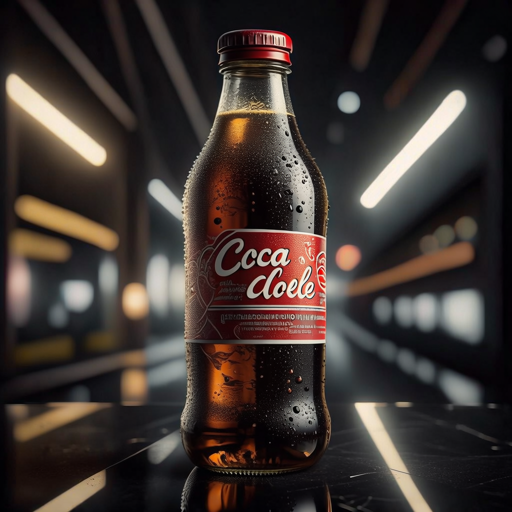

🖼️ parcial: https://d1ei2xrl63k822.cloudfront.net/api/res/efdd6ee6d6f94acd8f9fae718d1e8632.png?Expires=1766190751&Signature=BnolezdJqwY91VFHeJz1v5prrDMRpyw7DlzuhW3SdiDtxy6JcgqQqgX0iZKDlkYZqG9gNrzVCOF3wtivkpNforfcZfKMwfwhJke5Hz07HYo8yCesCXiCi3TVIA4UL9hpVg2e5nY4x5diYYv5RHemlZo0zZecN9r7IQFNzu21Nxn5W-YZcz5z4XvaKiHuZZT0EcHdcFdQJQKxTHmrnJwcZmhMxPi61Wg5CvabaMSVzBSlOsErI9k9AcsIU7SZ3bLtDanU0fVwJFSJDCT-EPh51thUWYye0m4JsSCwRP4DrBqmAWNzEwW5k2pJqU3U3dQfTP-Gu1yaIiep4pHJN9ZAgw__&Key-Pair-Id=K2UXO1NPZVKO7N
🖼️ parcial: https://d1ei2xrl63k822.cloudfront.net/api/res/efdd6ee6d6f94acd8f9fae718d1e8632.png?Expires=1766190751&Signature=BnolezdJqwY91VFHeJz1v5prrDMRpyw7DlzuhW3SdiDtxy6JcgqQqgX0iZKDlkYZqG9gNrzVCOF3wtivkpNforfcZfKMwfwhJke5Hz07HYo8yCesCXiCi3TVIA4UL9hpVg2e5nY4x5diYYv5RHemlZo0zZecN9r7IQFNzu21Nxn5W-YZcz5z4XvaKiHuZZT0EcHdcFdQJQKxTHmrnJwcZmhMxPi61Wg5CvabaMSVzBSlOsErI9k9AcsIU7SZ3bLtDanU0fVwJFSJDCT-EPh51thUWYye0m4JsSCwRP4DrBqmAWNzEwW5k2pJqU3U3dQfTP-Gu1yaIiep4pHJN9ZAgw__&Key-Pair-Id=K2UXO1NPZVKO7N
🖼️ parci

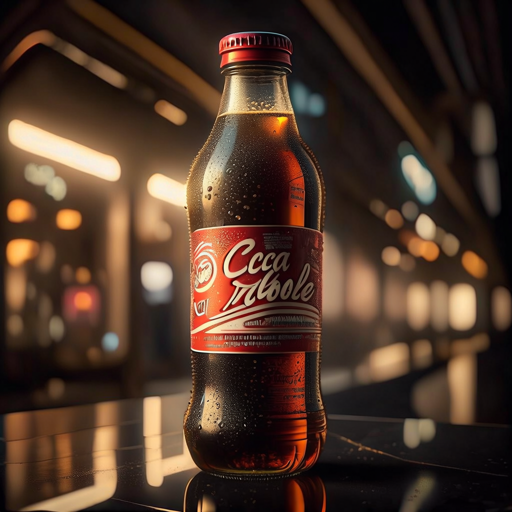

🖼️ parcial: https://d1ei2xrl63k822.cloudfront.net/api/res/efdd6ee6d6f94acd8f9fae718d1e8632.png?Expires=1766190751&Signature=BnolezdJqwY91VFHeJz1v5prrDMRpyw7DlzuhW3SdiDtxy6JcgqQqgX0iZKDlkYZqG9gNrzVCOF3wtivkpNforfcZfKMwfwhJke5Hz07HYo8yCesCXiCi3TVIA4UL9hpVg2e5nY4x5diYYv5RHemlZo0zZecN9r7IQFNzu21Nxn5W-YZcz5z4XvaKiHuZZT0EcHdcFdQJQKxTHmrnJwcZmhMxPi61Wg5CvabaMSVzBSlOsErI9k9AcsIU7SZ3bLtDanU0fVwJFSJDCT-EPh51thUWYye0m4JsSCwRP4DrBqmAWNzEwW5k2pJqU3U3dQfTP-Gu1yaIiep4pHJN9ZAgw__&Key-Pair-Id=K2UXO1NPZVKO7N
🖼️ parcial: https://d1ei2xrl63k822.cloudfront.net/api/res/de04fcf7d22e42a5b9a867307cd04ab7.png?Expires=1766190760&Signature=iCFIIY77x2zMED01Ez7vhoqeqpzYkS2jEukej803bSsSTnMHdklp6TK5e9coqXbuQO7mxD5EFweVXfyitpDPuV0me~ELuRtW0rStZKix~Sshft81vkH6Gqd1mgoPV-a2gjVNVLyfb-i7bhxk3g7DRQt6~qEd9ksDAfOiHEmL2b36EoyIhiXSLDWyaOiwU0mR7crZ17A9pFoKLdhdo8bgHXwRFcMlP8iYGW9pgzj7gQEjbylWIF0-sMbVpZ2oEUoR8JeA6HKVBBonkFOxX10F77JgA0xu0WcObDM8e01F7j7HdfDriXipMV7DcDKi7ikA8-KgnpTMItf0vRVjpH1Mww__&Key-Pair-Id=K2UXO1NPZVKO7N
🖼️ parci

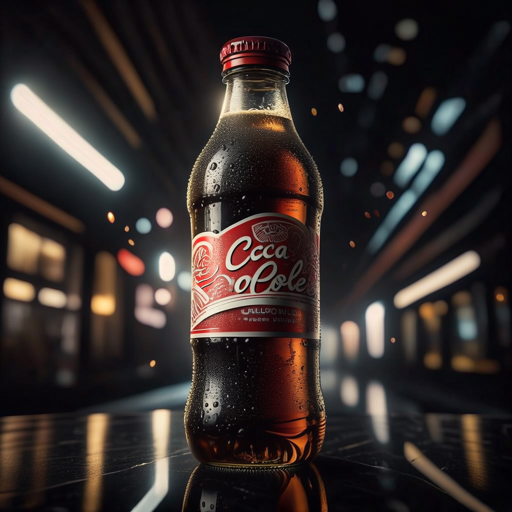

🖼️ parcial: https://d1ei2xrl63k822.cloudfront.net/api/res/efdd6ee6d6f94acd8f9fae718d1e8632.png?Expires=1766190751&Signature=BnolezdJqwY91VFHeJz1v5prrDMRpyw7DlzuhW3SdiDtxy6JcgqQqgX0iZKDlkYZqG9gNrzVCOF3wtivkpNforfcZfKMwfwhJke5Hz07HYo8yCesCXiCi3TVIA4UL9hpVg2e5nY4x5diYYv5RHemlZo0zZecN9r7IQFNzu21Nxn5W-YZcz5z4XvaKiHuZZT0EcHdcFdQJQKxTHmrnJwcZmhMxPi61Wg5CvabaMSVzBSlOsErI9k9AcsIU7SZ3bLtDanU0fVwJFSJDCT-EPh51thUWYye0m4JsSCwRP4DrBqmAWNzEwW5k2pJqU3U3dQfTP-Gu1yaIiep4pHJN9ZAgw__&Key-Pair-Id=K2UXO1NPZVKO7N
🖼️ parcial: https://d1ei2xrl63k822.cloudfront.net/api/res/de04fcf7d22e42a5b9a867307cd04ab7.png?Expires=1766190760&Signature=iCFIIY77x2zMED01Ez7vhoqeqpzYkS2jEukej803bSsSTnMHdklp6TK5e9coqXbuQO7mxD5EFweVXfyitpDPuV0me~ELuRtW0rStZKix~Sshft81vkH6Gqd1mgoPV-a2gjVNVLyfb-i7bhxk3g7DRQt6~qEd9ksDAfOiHEmL2b36EoyIhiXSLDWyaOiwU0mR7crZ17A9pFoKLdhdo8bgHXwRFcMlP8iYGW9pgzj7gQEjbylWIF0-sMbVpZ2oEUoR8JeA6HKVBBonkFOxX10F77JgA0xu0WcObDM8e01F7j7HdfDriXipMV7DcDKi7ikA8-KgnpTMItf0vRVjpH1Mww__&Key-Pair-Id=K2UXO1NPZVKO7N
🖼️ parci

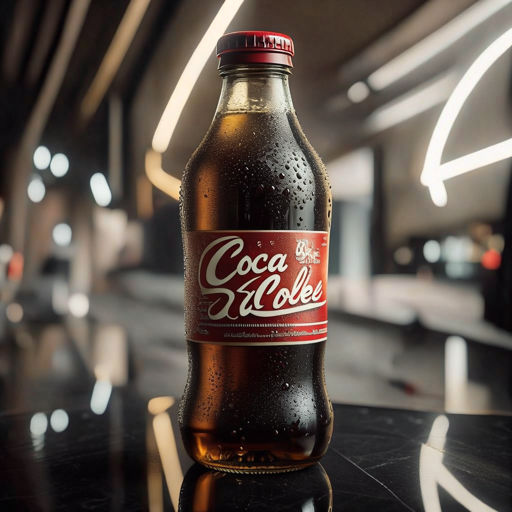


✅ FIN: DONE
🖼️ final: https://d1ei2xrl63k822.cloudfront.net/api/res/efdd6ee6d6f94acd8f9fae718d1e8632.png?Expires=1766190751&Signature=BnolezdJqwY91VFHeJz1v5prrDMRpyw7DlzuhW3SdiDtxy6JcgqQqgX0iZKDlkYZqG9gNrzVCOF3wtivkpNforfcZfKMwfwhJke5Hz07HYo8yCesCXiCi3TVIA4UL9hpVg2e5nY4x5diYYv5RHemlZo0zZecN9r7IQFNzu21Nxn5W-YZcz5z4XvaKiHuZZT0EcHdcFdQJQKxTHmrnJwcZmhMxPi61Wg5CvabaMSVzBSlOsErI9k9AcsIU7SZ3bLtDanU0fVwJFSJDCT-EPh51thUWYye0m4JsSCwRP4DrBqmAWNzEwW5k2pJqU3U3dQfTP-Gu1yaIiep4pHJN9ZAgw__&Key-Pair-Id=K2UXO1NPZVKO7N
🖼️ final: https://d1ei2xrl63k822.cloudfront.net/api/res/de04fcf7d22e42a5b9a867307cd04ab7.png?Expires=1766190760&Signature=iCFIIY77x2zMED01Ez7vhoqeqpzYkS2jEukej803bSsSTnMHdklp6TK5e9coqXbuQO7mxD5EFweVXfyitpDPuV0me~ELuRtW0rStZKix~Sshft81vkH6Gqd1mgoPV-a2gjVNVLyfb-i7bhxk3g7DRQt6~qEd9ksDAfOiHEmL2b36EoyIhiXSLDWyaOiwU0mR7crZ17A9pFoKLdhdo8bgHXwRFcMlP8iYGW9pgzj7gQEjbylWIF0-sMbVpZ2oEUoR8JeA6HKVBBonkFOxX10F77JgA0xu0WcObDM8e01F7j7HdfDriXipMV7DcDKi7ikA8-KgnpTMItf0vRVjpH1Mww__&Key-Pair-Id=K2UXO1NPZVKO7N

In [ ]:
#@title 🧪 3) Testing mejorado (async + progreso por etapas + resultados parciales)
DRIVE_PROJECT_FOLDER = "Hackathon Bria Fibo" #@param {type:"string"}
SERVICE_FOLDER_NAME = "llm_rag_service" #@param {type:"string"}

BRIA_API_TOKEN = "db81b51414d34465b1c7968dacaad14d" #@param {type:"string"}  # ⚠️ pega tu token aquí (solo runtime)
OLLAMA_MODEL = "deepseek-r1:8b" #@param {type:"string"}

PORT = 8001 #@param {type:"integer"}
VARIATIONS = 4 #@param {type:"integer"}
ASPECT_RATIO = "1:1" #@param {type:"string"}

PROMPT = "Create Cinematic Shot for this product, keeping the label " #@param {type:"string"}
BRAND_GUIDELINES = "Brand: minimal, premium. Use accent color #FF5733. Softbox lighting. Clean backgrounds." #@param {type:"string"}

import os, time, requests
from pathlib import Path
from google.colab import drive, files
from PIL import Image
from io import BytesIO

drive.mount("/content/drive", force_remount=False)

SERVICE_DIR = Path("/content/drive/MyDrive") / DRIVE_PROJECT_FOLDER / SERVICE_FOLDER_NAME
assert (SERVICE_DIR / "app.py").exists(), f"No encuentro app.py en {SERVICE_DIR}. Ejecuta la Celda 2 primero."

# Env
os.environ["BRIA_API_TOKEN"] = BRIA_API_TOKEN
os.environ["BRIA_V2_BASE_URL"] = "https://engine.prod.bria-api.com/v2"
os.environ["OLLAMA_MODEL"] = OLLAMA_MODEL
os.environ["DEFAULT_VARIATIONS"] = str(VARIATIONS)
os.environ["LLM_RAG_ROOT"] = str(SERVICE_DIR)

# Kill server viejo
!pkill -f "uvicorn app:app" || true
!pkill -f "python -m uvicorn app:app" || true

# Start server
print(f"🚀 Levantando Uvicorn en puerto {PORT} ...")
!nohup python -m uvicorn app:app --app-dir "{SERVICE_DIR}" --host 0.0.0.0 --port {PORT} --log-level info > /tmp/llm_rag_api.log 2>&1 &

base = f"http://127.0.0.1:{PORT}"

# Wait health
ok = False
for _ in range(30):
    try:
        r = requests.get(base + "/health", timeout=2)
        if r.status_code == 200:
            print("✅ Health:", r.json())
            ok = True
            break
    except Exception:
        pass
    time.sleep(1)

if not ok:
    print("❌ Server no levantó. Logs:")
    !tail -n 200 /tmp/llm_rag_api.log
    raise SystemExit("No server")

# Upload image
print("📤 Sube una imagen de producto:")
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Start async job
with open(img_path, "rb") as f:
    rr = requests.post(
        base + "/api/v1/generate-async",
        files={"image": (img_path, f, "application/octet-stream")},
        data={
            "prompt": PROMPT,
            "brand_guidelines": BRAND_GUIDELINES,
            "variations": str(VARIATIONS),
            "aspect_ratio": ASPECT_RATIO,
        },
        timeout=60,
    )

print("HTTP", rr.status_code)
if rr.status_code != 200:
    print(rr.text)
    !tail -n 200 /tmp/llm_rag_api.log
    raise SystemExit("❌ No pude crear job")

job_id = rr.json()["job_id"]
print("✅ job_id:", job_id)

# Poll job progress
seen_urls = set()

def show_url(url: str, max_side: int = 512):
    if not url or url in seen_urls:
        return
    seen_urls.add(url)
    try:
        r = requests.get(url, timeout=60)
        im = Image.open(BytesIO(r.content)).convert("RGB")
        im.thumbnail((max_side, max_side))
        display(im)
    except Exception as e:
        print("⚠️ No pude mostrar url:", url, "err:", e)

last_stage = None
for _ in range(600):  # hasta 10 min
    j = requests.get(base + f"/api/v1/jobs/{job_id}", timeout=10).json()
    stage = j.get("stage")
    prog = j.get("progress")
    done = j.get("done", 0)
    total = j.get("total", VARIATIONS)

    if stage != last_stage:
        print(f"\n🧩 stage={stage} | progress={prog}% | done={done}/{total}")
        # mostrar los últimos eventos
        ev = j.get("events", [])[-5:]
        for e in ev:
            print("  -", e.get("msg"))
        last_stage = stage

    # mostrar parciales si aparecen
    for pr in j.get("partial_results", []) or []:
        url = pr.get("image_url")
        if isinstance(url, list) and url:
            url = url[0]
        if isinstance(url, str) and url.startswith("http"):
            print("🖼️ parcial:", url)
            show_url(url)

    if stage in ("DONE", "ERROR"):
        print("\n✅ FIN:", stage)
        if stage == "ERROR":
            print("error:", j.get("error"))
            print("trace:", (j.get("trace") or "")[:1200])
        else:
            # muestra finales
            for it in (j.get("results") or []):
                url = it.get("image_url")
                if isinstance(url, list) and url:
                    url = url[0]
                if isinstance(url, str) and url.startswith("http"):
                    print("🖼️ final:", url)
                    show_url(url)
        break

    time.sleep(1)

print("\n🧾 Logs server (cola):")
!tail -n 120 /tmp/llm_rag_api.log


In [ ]:
#@title 🛠️ FIX app.py (String unterminated + CORS estable)
DRIVE_PROJECT_FOLDER = "Hackathon Bria Fibo" #@param {type:"string"}
SERVICE_FOLDER_NAME = "llm_rag_service" #@param {type:"string"}

import os, re
from pathlib import Path
from google.colab import drive

drive.mount("/content/drive", force_remount=False)

SERVICE_DIR = Path("/content/drive/MyDrive") / DRIVE_PROJECT_FOLDER / SERVICE_FOLDER_NAME
app_path = SERVICE_DIR / "app.py"
assert app_path.exists(), f"❌ No encuentro app.py en: {app_path}"

code = app_path.read_text(encoding="utf-8")

# 1) Asegurar import CORSMiddleware
if "from fastapi.middleware.cors import CORSMiddleware" not in code:
    # intenta insertarlo justo después del import de fastapi
    code = code.replace(
        "from fastapi import FastAPI, File, Form, HTTPException, UploadFile",
        "from fastapi import FastAPI, File, Form, HTTPException, UploadFile\nfrom fastapi.middleware.cors import CORSMiddleware"
    )

# 2) Reparar el bloque dentro de build_app: reemplazar todo entre "app = FastAPI(" y "orch = Orchestrator(cfg)"
lines = code.splitlines()

def find_idx(substr, start=0, end=None):
    if end is None: end = len(lines)
    for i in range(start, end):
        if substr in lines[i]:
            return i
    return -1

idx_build = find_idx("def build_app", 0)
if idx_build == -1:
    raise SystemExit("❌ No encontré def build_app(...). app.py no tiene la estructura esperada.")

idx_orch = find_idx("orch = Orchestrator(cfg)", idx_build)
if idx_orch == -1:
    raise SystemExit("❌ No encontré 'orch = Orchestrator(cfg)'. No puedo parchear seguro.")

# buscar hacia arriba el inicio del statement app = FastAPI
idx_app = -1
for i in range(idx_orch, idx_build, -1):
    if "app = FastAPI" in lines[i]:
        idx_app = i
        break

# si no lo encuentra (por estar roto en múltiples líneas), buscamos el primer rastro de FastAPI(
if idx_app == -1:
    for i in range(idx_build, idx_orch):
        if "FastAPI(" in lines[i]:
            idx_app = i
            break

if idx_app == -1:
    raise SystemExit("❌ No encontré dónde se instancia FastAPI(...) dentro de build_app.")

# Reemplazo limpio (con indent de 4 espacios)
replacement_block = [
    '    app = FastAPI(title="Bria FIBO — AI Art Director (LLM+RAG)", version="0.1.0")',
    '    # --- CORS (necesario para navegador / AI Studio)',
    '    allow = os.environ.get("CORS_ALLOW_ORIGINS", "*").strip()',
    '    origins = ["*"] if allow == "*" else [o.strip() for o in allow.split(",") if o.strip()]',
    '    app.add_middleware(',
    '        CORSMiddleware,',
    '        allow_origins=origins,',
    '        allow_credentials=False,',
    '        allow_methods=["*"],',
    '        allow_headers=["*"],',
    '    )',
    '    orch = Orchestrator(cfg)',
]

# OJO: borramos TODO lo que haya entre idx_app y idx_orch (inclusive idx_orch), y ponemos el bloque limpio
new_lines = lines[:idx_app] + replacement_block + lines[idx_orch+1:]

fixed = "\n".join(new_lines) + "\n"
app_path.write_text(fixed, encoding="utf-8")

print("✅ Reparado:", app_path)
print("✅ Bloque FastAPI + CORS reescrito sin strings rotos.")
print("👉 Ahora ejecuta la celda 2 para levantar uvicorn + ngrok.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Reparado: /content/drive/MyDrive/Hackathon Bria Fibo/llm_rag_service/app.py
✅ Bloque FastAPI + CORS reescrito sin strings rotos.
👉 Ahora ejecuta la celda 2 para levantar uvicorn + ngrok.


In [ ]:
#@title 🌐 Levantar Uvicorn + ngrok (sin testing, listo para AI Studio) ✅
DRIVE_PROJECT_FOLDER = "Hackathon Bria Fibo" #@param {type:"string"}
SERVICE_FOLDER_NAME = "llm_rag_service" #@param {type:"string"}
PORT = 8001 #@param {type:"integer"}

# Tokens (pégalos aquí UNA vez por runtime)
NGROK_AUTHTOKEN = "31O6TDiHGfmO0iwIJCuVPtMOgMI_2uRR2x7XnYf7vM63gBTMb" #@param {type:"string"}
NGROK_REGION = "us" #@param ["us","eu","ap","au","sa","jp","in"]

BRIA_API_TOKEN = "db81b51414d34465b1c7968dacaad14d" #@param {type:"string"}
BRIA_V2_BASE_URL = "https://engine.prod.bria-api.com/v2" #@param {type:"string"}

OLLAMA_HOST = "http://127.0.0.1:11434" #@param {type:"string"}
OLLAMA_MODEL = "deepseek-r1:8b" #@param {type:"string"}

# CORS para navegador / AI Studio
CORS_ALLOW_ORIGINS = "*" #@param {type:"string"}

KEEP_ALIVE = True #@param {type:"boolean"}

import os, time, subprocess, signal
from pathlib import Path
from google.colab import drive

drive.mount("/content/drive", force_remount=False)

SERVICE_DIR = Path("/content/drive/MyDrive") / DRIVE_PROJECT_FOLDER / SERVICE_FOLDER_NAME
assert (SERVICE_DIR / "app.py").exists(), f"❌ No encuentro app.py en {SERVICE_DIR}"

!pip -q install pyngrok fastapi uvicorn[standard] python-multipart requests pillow ollama

# env vars
os.environ["LLM_RAG_ROOT"] = str(SERVICE_DIR)
os.environ["BRIA_API_TOKEN"] = BRIA_API_TOKEN
os.environ["BRIA_V2_BASE_URL"] = BRIA_V2_BASE_URL
os.environ["OLLAMA_HOST"] = OLLAMA_HOST
os.environ["OLLAMA_MODEL"] = OLLAMA_MODEL
os.environ["CORS_ALLOW_ORIGINS"] = CORS_ALLOW_ORIGINS

if not NGROK_AUTHTOKEN.strip():
    raise SystemExit("❌ Falta NGROK_AUTHTOKEN.")

# kill previous uvicorn
!pkill -f "uvicorn app:app" || true
!pkill -f "python -m uvicorn app:app" || true

log_path = "/tmp/llm_rag_api.log"
open(log_path, "w").close()

print(f"🚀 Starting uvicorn on 0.0.0.0:{PORT} ...")
proc = subprocess.Popen(
    ["python","-m","uvicorn","app:app",
     "--app-dir", str(SERVICE_DIR),
     "--host","0.0.0.0",
     "--port", str(PORT),
     "--log-level","info"],
    stdout=open(log_path, "a"),
    stderr=subprocess.STDOUT,
    preexec_fn=os.setsid
)
print("✅ Uvicorn PID:", proc.pid)

# wait listening
ready = False
for _ in range(40):
    if proc.poll() is not None:
        print("❌ Uvicorn murió. Logs:")
        !tail -n 200 /tmp/llm_rag_api.log
        raise SystemExit("Uvicorn process exited")
    out = subprocess.getoutput(f"ss -lnt | grep -E ':{PORT}\\s'")
    if out.strip():
        ready = True
        break
    time.sleep(1)

if not ready:
    print("❌ No quedó escuchando. Logs:")
    !tail -n 200 /tmp/llm_rag_api.log
    raise SystemExit("Port not listening")

from pyngrok import ngrok, conf
conf.get_default().region = NGROK_REGION
ngrok.set_auth_token(NGROK_AUTHTOKEN)

try:
    ngrok.kill()
except Exception:
    pass

# ngrok connect (firma compatible)
try:
    tunnel = ngrok.connect(PORT, "http", bind_tls=True)
except TypeError:
    tunnel = ngrok.connect(PORT, "http")

public_url = tunnel.public_url
if public_url.startswith("http://"):
    public_url = public_url.replace("http://", "https://", 1)

print("\n🌍 BASE_URL para AI Studio:", public_url)
print("📄 Swagger:", public_url + "/docs")
print("🧾 OpenAPI:", public_url + "/openapi.json")
print("\n✅ Para evitar el warning de ngrok en algunos clientes, manda header:")
print('   ngrok-skip-browser-warning: 1')

if KEEP_ALIVE:
    print("\n🟢 KEEP_ALIVE activo. CTRL+C para detener.")
    try:
        while True:
            if proc.poll() is not None:
                print("\n❌ Uvicorn murió. Logs:")
                !tail -n 200 /tmp/llm_rag_api.log
                raise SystemExit("Uvicorn exited")
            time.sleep(25)
    except KeyboardInterrupt:
        print("\n🛑 Deteniendo...")
        try: ngrok.kill()
        except Exception: pass
        try: os.killpg(os.getpgid(proc.pid), signal.SIGTERM)
        except Exception: pass
        print("✅ Detenido.")


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.7/517.7 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.8/456.8 kB 42.0 MB/s eta 0:00:00
^C
^C
🚀 Starting uvicorn on 0.0.0.0:8001 ...
✅ Uvicorn PID: 879

🌍 BASE_URL para AI Studio: https://precrystalline-arabella-tuberoid.ngrok-free.dev
📄 Swagger: https://precrystalline-arabella-tuberoid.ngrok-free.dev/docs
🧾 OpenAPI: https://precrystalline-arabella-tuberoid.ngrok-free.dev/openapi.json

✅ Para evitar el warning de ngrok en algunos clientes, manda header:
   ngrok-skip-browser-warning: 1

🟢 KEEP_ALIVE activo. CTRL+C para detener.
